# Calculate price-equilibrium using simulations

In [4]:
import sys, numpy as np, scipy
from sympy import symbols
from typing import Callable
from log_progress import log_progress
np.random.seed(None)

import matplotlib.pyplot as plt, mpld3
%matplotlib inline
mpld3.enable_notebook()  # to zoom and move in plots

resetSize,r,zmin,zmax,beta,D,L,Supply = symbols('a r  z_{\min} z_{\max} \\beta \\Delta \\ell \\tau', positive=True,finite=True,real=True)
params = {
    L: 10,           # total transfers per pair per day.
    D: 6,            # delta transfers per day (Alice-to-Bob minus Bob-to-Alice) in the asymmetric case.
    beta: 0.01,      # value / transfer-size
    r: 4/100/365,    # interest rate per day
    resetSize: 1.1,  # records per reset tx
    Supply: 288000,  # records per day
    zmin: 0.001,     # min transfer size in bitcoins (for power law distribution)
    zmax: 1,         # max transfer size in bitcoins (for uniform distribution)
}
# NOTE: These are the same params used in the symbolic comnputations (market-equilibrium notebook).

In [5]:
if "Simulation" in sys.modules: del sys.modules["Simulation"]
from Simulation import *
#sim = UniformSymmetricSimulation(params, numOfDays=1000, filenamePrefix="interpolation-tables/uniform-symmetric-1000days")
sim = PowerlawSymmetricSimulation(params, numOfDays=1000, filenamePrefix="interpolation-tables/powerlaw-symmetric-1000days") 
sim.loadTables()

Simulation.py version 1.0


## Find the optimal reset-radius

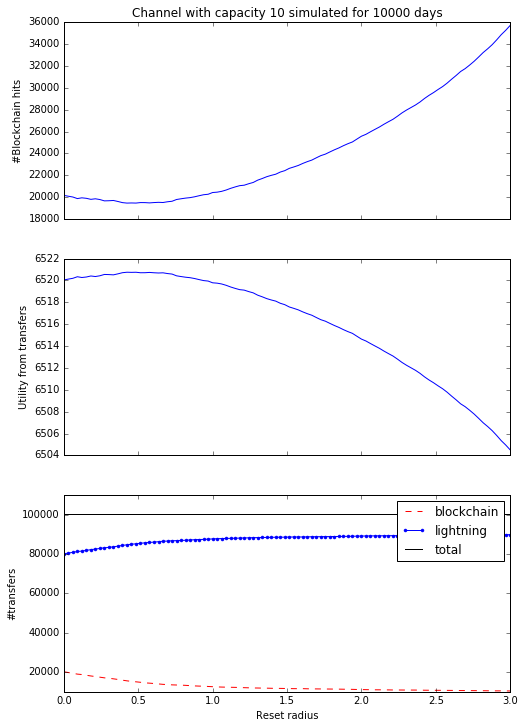

In [8]:
sim.plotBlockchainHitsVsResetRadiuses(
    numOfDays=10000, 
    channelCapacity=10, 
    resetRadiuses=np.linspace(0,3,100), 
    blockchainFee=.001)
    # Note: the graph looks almost the same when minBlockchainTransferSize is anywhere between 0 and 0.5.

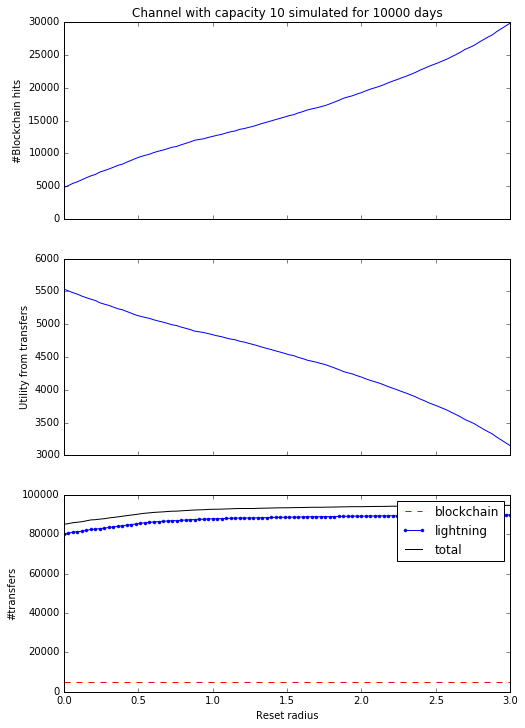

In [9]:
sim.plotBlockchainHitsVsResetRadiuses(
    numOfDays=10000, 
    channelCapacity=10, 
    resetRadiuses=np.linspace(0,3,100), 
    blockchainFee=.1)
    # Note: the graph looks almost the same when minBlockchainTransferSize is anywhere between 0 and 0.5.

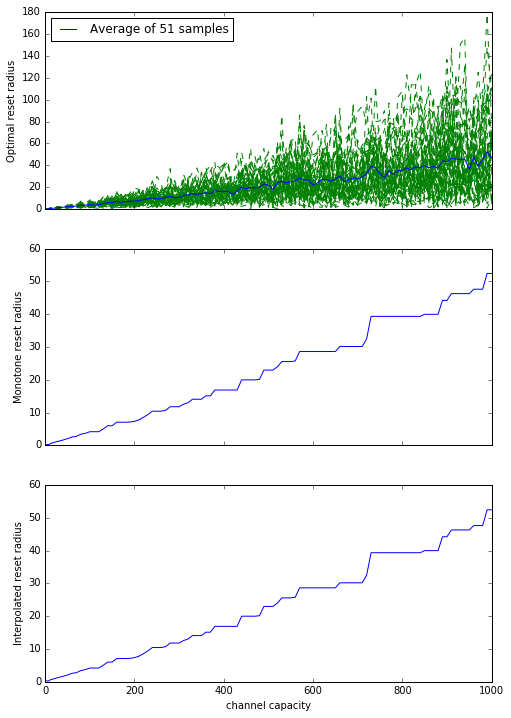

In [3]:
sampleCapacities = np.concatenate((np.linspace(1,30, 30),np.linspace(30,1000, 98)))
sim.calculateOptimalResetRadiusTable(
    numOfDays=1000, 
    channelCapacities=sampleCapacities, 
    blockchainFee=0.001,
    numOfSamples=51,
    recreateAllSamples=False,   # False means to reuse the existing samples and calculate only numOfSamples-numOfExistingSamples new samples.
    )
sim.saveTables()
sim.plotOptimalResetRadiusTable()

## Find the optimal channel capacity

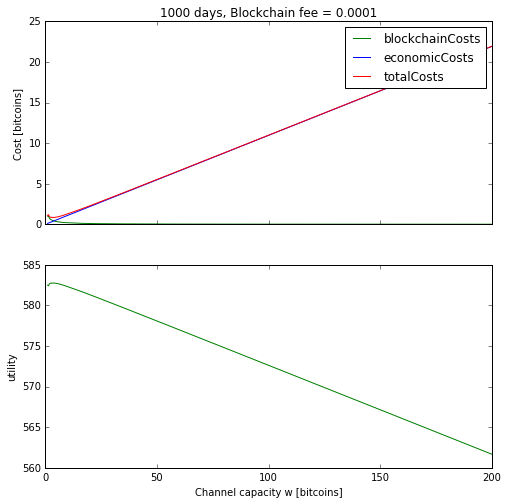

In [5]:
sim.plotCostsVsChannelCapacity(
    numOfDays=1000, 
    blockchainFee=0.0001, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

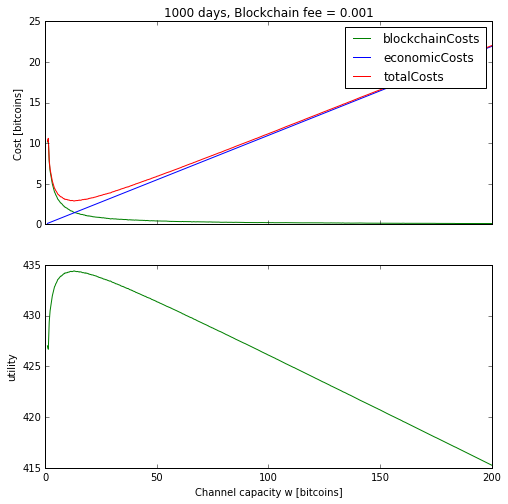

In [4]:
sim.plotCostsVsChannelCapacity(
    numOfDays=1000, 
    blockchainFee=0.001, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

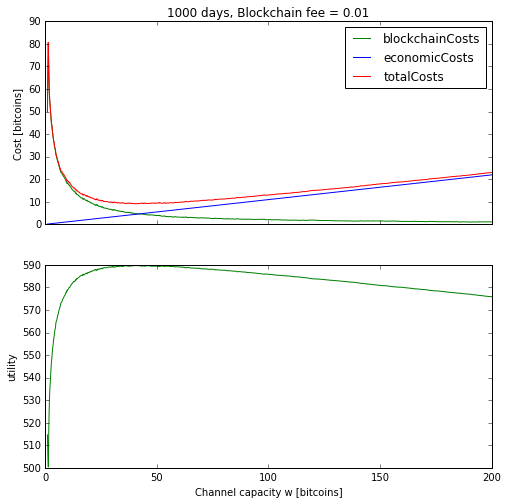

In [81]:
sim.plotCostsVsChannelCapacity(
    numOfDays=1000, 
    blockchainFee=0.01, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

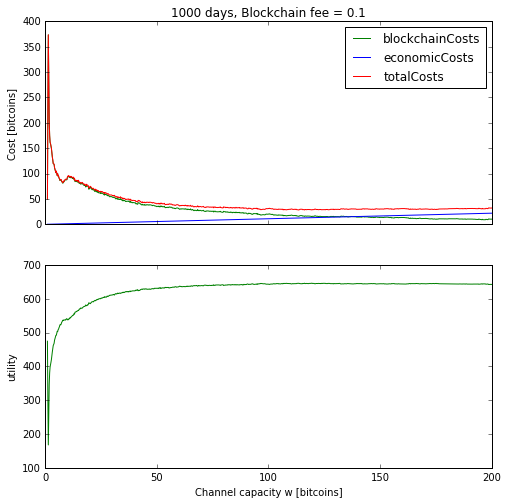

In [6]:
sim.plotCostsVsChannelCapacity(
    numOfDays=1000, 
    blockchainFee=0.1, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

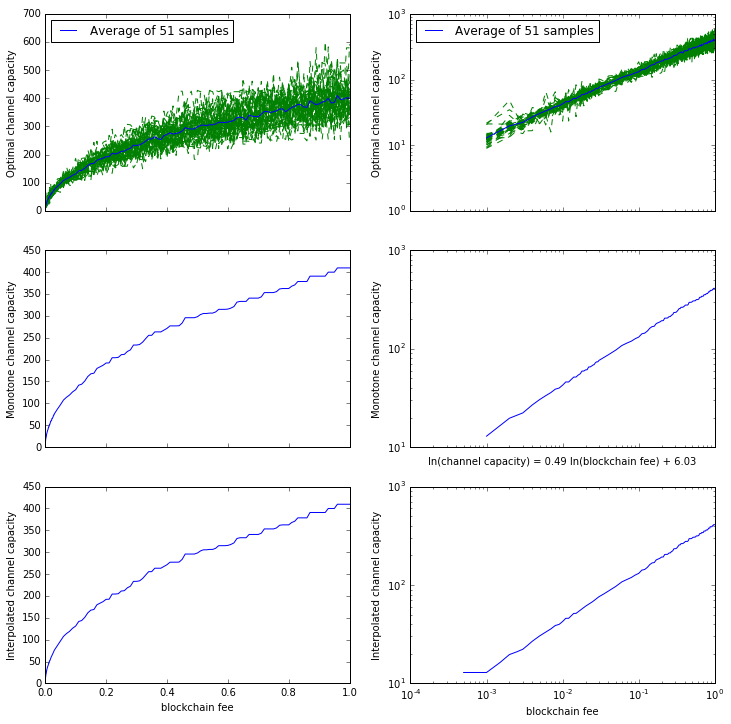

In [11]:
sampleBlockchainFees = np.concatenate((np.linspace(1,30, 30),np.linspace(30,1000, 98)))/1000
sim.calculateOptimalChannelCapacityTable(
    numOfDays=1000, 
    blockchainFees=sampleBlockchainFees,
    numOfSamples=51,
    recreateAllSamples=False,  # False means to reuse the existing samples and calculate only numOfSamples-numOfExistingSamples new samples.
    )
sim.saveTables()
sim.plotOptimalChannelCapacityTable()

## Find the market-equilibrium price

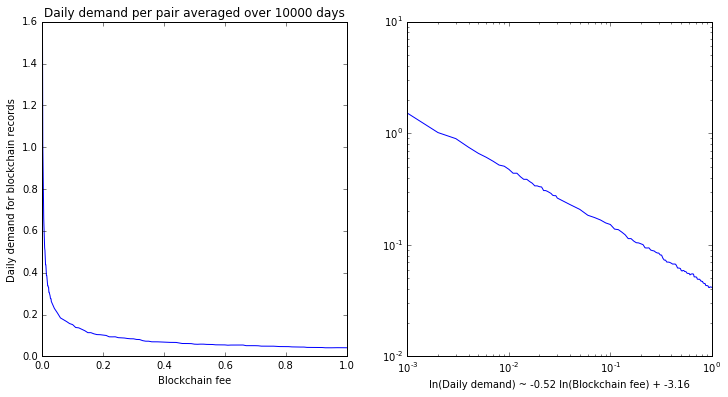

In [12]:
sim.plotDailyDemandVsBlockchainFee(numOfDays=10000, blockchainFees=sampleBlockchainFees)

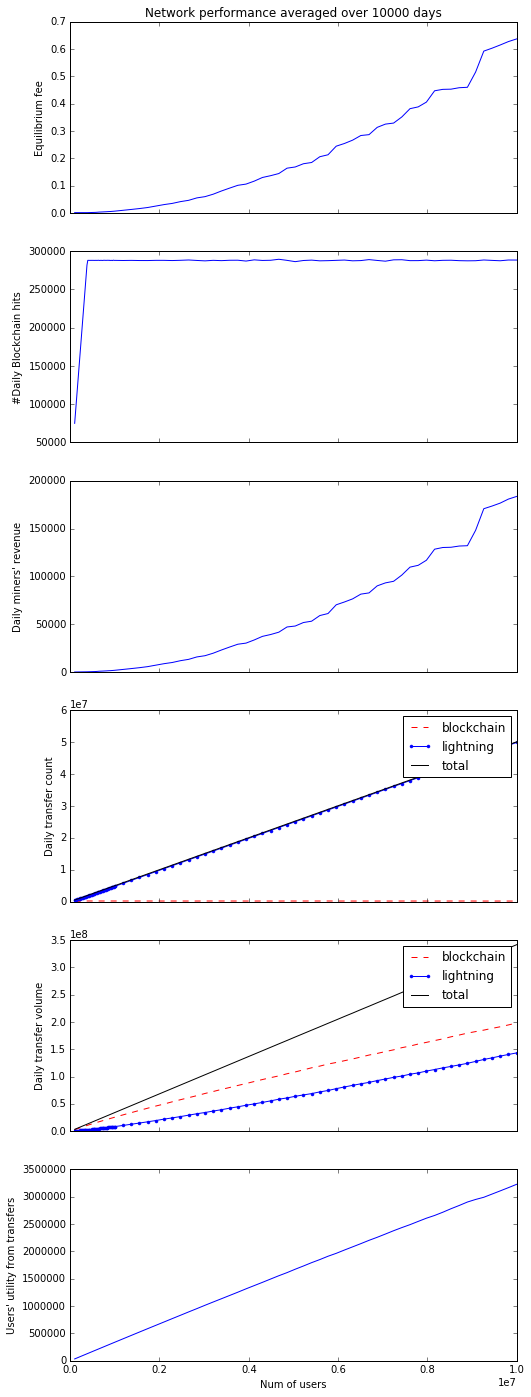

In [4]:
numsOfUsers = np.concatenate((np.linspace(1e5, 10e5, 50), np.linspace(10e5, 100e5, 50)))
sim.plotNetworkPerformanceVsNumOfUsers(numOfDays=10000, numsOfUsers=numsOfUsers)